In [4]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pysolar.solar as solar
import pytz
from scipy.optimize import minimize 
import random

# <font color = 'red'> PRIORITY: CLEAN THIS FILE, PERHAPS SEPARATE INTO MULTIPLE FILES, BUT MY WORK NEEDS TO BE EASILY REVISITABLE, EDITABLE AND MODULAR BEFORE PROCEEDING!!! </font>

Literature:
0. https://www.mdpi.com/1996-1073/8/11/13265#B50-energies-08-12368
1. https://iopscience.iop.org/article/10.1088/1748-9326/abe2d0/meta
2. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4158436
3. https://www.sciencedirect.com/science/article/pii/S036054421730035X?casa_token=aZ2JAJgflnAAAAAA:uJtsREReIdnZcFjf0pylw6_9xwicgqPxUrbko2c3YhW8VPusBwW9DJdxqPgbSSDy5qpH-UvW#sec2
4. https://www.sciencedirect.com/science/article/pii/S0959652615012421
5. https://reader.elsevier.com/reader/sd/pii/S0959652615012421?token=EF2E89D3396AEAE206E6A897F0073D5701BCADB89B42115A30D8960C0AE96213F23D2533CAB326B69CF09E6532C0CF59&originRegion=eu-west-1&originCreation=20230517123628
6. https://www.sciencedirect.com/science/article/pii/S221067071731661X?casa_token=PIEIFrlOXdQAAAAA:BVfv43hMShf6bgnV6VPiMekQiTCGf9DVmbJb6wHIi9No8_XRtmnq87Qk6VLkmO8abh6zgy4p#sec0055
7. https://reader.elsevier.com/reader/sd/pii/S0360544219307285?token=83B2FA46A87D8D910245DA51B434FBDEE43F33141BACC4673F418F64FF9830ACA7636ED74227DBB4D7F13913B6F8328C&originRegion=eu-west-1&originCreation=20230519160000
8. https://www.researchgate.net/publication/272158701_Design_of_a_photovoltaic-wind_charging_station_for_small_electric_Tuk-tuk_in_DRCongo
9. https://www.rees-journal.org/articles/rees/full_html/2016/01/rees160014-s/rees160014-s.html
10. https://reader.elsevier.com/reader/sd/pii/S221067071731661X?token=F2BDBD83F51D927C33E0D58456D0565614A34CD224F4ECD1146C06B5D284C98100B2AA1CF35A4EF8A3A2F66FF8465F12&originRegion=eu-west-1&originCreation=20230518134654
11. https://www.sciencedirect.com/science/article/pii/S221067071731661X?casa_token=PIEIFrlOXdQAAAAA:BVfv43hMShf6bgnV6VPiMekQiTCGf9DVmbJb6wHIi9No8_XRtmnq87Qk6VLkmO8abh6zgy4p#sec0055

## EV charging Load profile simulation

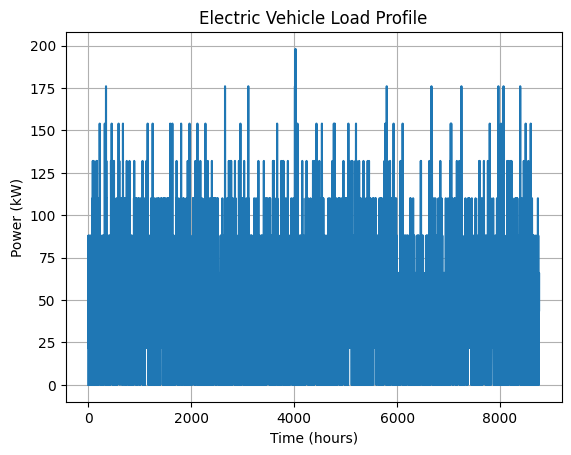

In [5]:
def simulate_charging_load_profile(total_days, total_time,
                             time_resolution,
                             num_vehicles,
                             charging_power):
    '''
    This function simulates a charging load profile for a fleet of EVs at a charging station, given the number of EVs, the charging power, the total simulation time, and the desired time resolution
    
    '''
    
    # Generate random charging start times and durations for each EV
    np.random.seed(42)  # Set a seed for reproducibility
    start_times = np.random.uniform(low=0, high=total_time, size=(num_vehicles, total_days))
    durations = np.random.uniform(low=1, high=4, size=(num_vehicles, total_days))

    # Create the time axis
    time = np.arange(0, total_time, time_resolution)

    # Initialize the load profile
    load_profile = np.zeros_like(time)

    # Calculate the EV load profile for each day
    for day in range(total_days):
        for i in range(num_vehicles):
            start_time = start_times[i, day]
            duration = durations[i, day]
            end_time = start_time + duration

            # Calculate the charging load during the charging period
            mask = (time >= start_time) & (time < end_time)
            load_profile[mask] += charging_power

    # Plot the EV load profile
    plt.plot(time, load_profile)
    plt.xlabel('Time (hours)')
    plt.ylabel('Power (kW)')
    plt.title('Electric Vehicle Load Profile')
    plt.grid(True)
    plt.show()
    
    return load_profile 


# Simulation parameters
total_days = 365  # Total number of days to simulate
total_time = 24 * total_days  # Total simulation time in hours
time_resolution = 1  # Time resolution in hours (e.g., 0.25 means 15 minutes)
num_vehicles = 20  # Number of EVs in the simulation
charging_power = 22  # Charging power in kW (e.g., Level 2 charging)


load_profile = simulate_charging_load_profile(total_days, total_time, time_resolution, num_vehicles, charging_power)

## Insolation profile simulation

/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: overflow encountered in exp
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime
/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: invalid value encountered in scalar multiply
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime


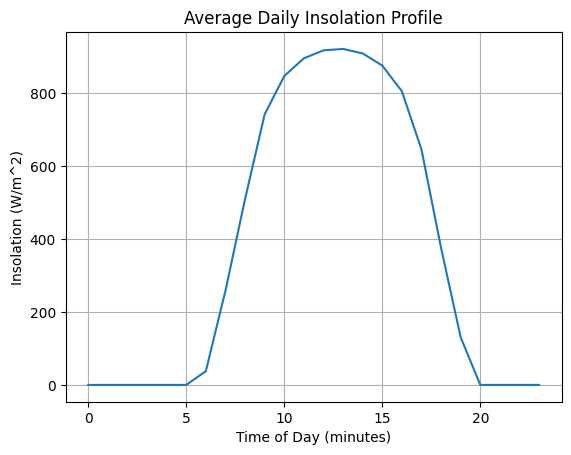

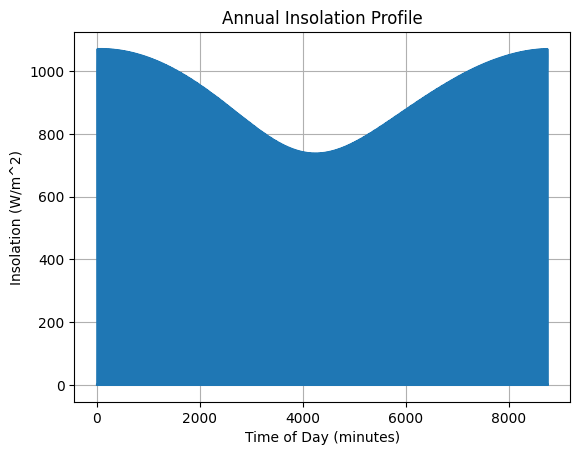

In [6]:
def simulate_insolation_profile(latitude, longitude, time_resolution, timezone):
    '''
    This function simulates a solar insolation profile for a given location and time period, as well as the average daily insolation profile for the same location. The function returns the simulated insolation profile and the average daily insolation profile'''

    # Get the current year
    current_year = datetime.datetime.now().year

    # Create a datetime object for the start of the year
    start_time = timezone.localize(datetime.datetime(current_year, 1, 1))

    # Create a datetime object for the start of the next year
    end_time = start_time + datetime.timedelta(days=365)

    # Initialize an array to store the accumulated insolation for each time step
    insolation_accumulated = np.zeros(int(24 * 60 / time_resolution))

    # Initialize a counter for the number of days
    num_days = 0

    # Initialize a list to hold values for all of the hours
    annual_insolation_profile = []

    # Iterate over each day of the year
    time = start_time
    while time < end_time:
        # Calculate the insolation for each time step of the day
        for t in range(int(24 * 60 / time_resolution)):
            time_step = time + datetime.timedelta(minutes=t * time_resolution)
            altitude_deg = solar.get_altitude(latitude, longitude, time_step)
            insolation = solar.radiation.get_radiation_direct(time_step, altitude_deg)
            
            # Check for NaN values and accumulate the insolation
            if not np.isnan(insolation):
                insolation_accumulated[t] += insolation
                annual_insolation_profile.append(insolation)
            else:
                annual_insolation_profile.append(0)
        
        # Increment the day counter
        num_days += 1
        
        # Move to the next day
        time += datetime.timedelta(days=1)

    # Calculate the average insolation for each time step
    daily_insolation_profile = insolation_accumulated / num_days
    
    
    # Calculate the average insolation for each time step
    insolation_profile = insolation_accumulated / num_days

    # Plot the average daily insolation profile
    plt.plot(insolation_profile)
    plt.xlabel('Time of Day (minutes)')
    plt.ylabel('Insolation (W/m^2)')
    plt.title('Average Daily Insolation Profile')
    plt.grid(True)
    plt.show()


    # Plot the annual insolation profile
    plt.plot(annual_insolation_profile)
    plt.xlabel('Time of Day (minutes)')
    plt.ylabel('Insolation (W/m^2)')
    plt.title('Annual Insolation Profile')
    plt.grid(True)
    plt.show()
    
    
    return daily_insolation_profile, annual_insolation_profile 
# Location coordinates (latitude, longitude)
latitude = -33.9321  # Stellenbosch, SA
longitude = 18.8602

# Time resolution in minutes
time_resolution = 60

# Set the time zone
timezone = pytz.timezone('Africa/Cairo')  # Set your desired time zone

daily_insolation_profile, annual_insolation_profile = simulate_insolation_profile(latitude, longitude, time_resolution, timezone)



## PV Output Simulation

In [7]:
def get_pv_output(insolation_profile, pv_efficiency, pv_capacity):
    '''
    This function obtains the solar PV output profile given a solar insolation profile, PV efficiency, and PV capacity. The function returns the PV output profile.'''

    # Calculate daily PV output profile
    pv_output_profile = [pv_capacity * pv_efficiency * i / 1000 for i in insolation_profile]

    # # Plot the average daily PV output profile 
    # plt.plot(pv_output_profile)
    # plt.xlabel('Time of Day (minutes)')
    # plt.ylabel('PV Output (kW)')
    # plt.grid(True)
    # plt.show()
    
    return pv_output_profile



# PV system specifications
pv_capacity = load_profile.max() * 0.20  # kW
efficiency = 0.85  # 85% efficiency
pv_output_profile = get_pv_output(annual_insolation_profile, efficiency, pv_capacity)

## Co-located storage simulation

Simulate battery charging

In [54]:
def simulate_battery_storage(load_profile, pv_output_profile, max_battery_capacity):
    battery_state = 0  # Initial state of the battery

    storage_profile = np.zeros(len(pv_output_profile)) # Initialize an array to keep track of the energy stored in the battery
    discharge_profile = np.zeros(len(pv_output_profile)) # Initialize an array to keep track of the energy discharged from the battery
    curtailed_energies = np.zeros(len(pv_output_profile)) # Initialize an array to keep track of the wasted energies
    battery_states = np.zeros(len(pv_output_profile)) # Initialize an array to keep track of the battery state

    for hour, load in enumerate(load_profile):
        net_load = load - pv_output_profile[hour]  # Calculate the net load profile
        
        battery_room = max_battery_capacity - battery_state # Calculate the amount of room left in the battery
        
        energy_stored = 0
        energy_discharged = 0
        curtailed_energy = 0
        
        if net_load < 0:
            # The PV system is producing more energy than the load requires
            # Charge the battery with the excess energy
            energy_stored = min(battery_room, -net_load)
            battery_state = battery_state + energy_stored
            curtailed_energy = -net_load - energy_stored
            
        elif net_load > 0:
            # The PV system is producing less energy than the load requires
            # Discharge the battery to assist with the load 
            energy_discharged = min(battery_state, net_load)
            battery_state = battery_state - energy_discharged
            
        curtailed_energies[hour] = curtailed_energy
        battery_states[hour] = battery_state
        storage_profile[hour] = energy_stored
        discharge_profile[hour] = energy_discharged
        
    pv_with_battery_output_profile = pv_output_profile + discharge_profile - storage_profile 
  #  load_profile_with_battery = load_profile - pv_with_battery_output_profile
    
    return pv_with_battery_output_profile

pv_with_battery_output_profile = simulate_battery_storage(load_profile, pv_output_profile, max_battery_capacity)


# print('total load (kWh):', load_profile.sum())
# net_load_with_tariff = (load_profile - pv_output_profile)
# print(' net load sans battery with abililty to sell to grid (kWh): ', net_load_with_tariff.sum())
# net_load_without_tariff = net_load_with_tariff[net_load_with_tariff > 0]
# print(' net load sans battery without ability to sell to grid (kWh): ', net_load_without_tariff.sum())
# load_profile_with_battery = (load_profile - pv_output_profile - discharge_profile + storage_profile)
# load_profile_with_battery =  load_profile_with_battery[load_profile_with_battery > 0]
# print('net load with battery without ability to sell to grid (kWh): ', load_profile_with_battery.sum())

# print("battery saves ",net_load_without_tariff.sum() - load_profile_with_battery.sum(), "kWh from being curtailed")
# print("that's pretty much", energy_usage_cost * (net_load_without_tariff.sum() - load_profile_with_battery.sum()), "dollars saved")
    

## Net load profile simulation

In [10]:
# Calculate net load profile
net_load_profile = load_profile - pv_output_profile



In [11]:
def get_cost_of_charging(load_profile: np.ndarray, net_load_profile: np.ndarray,
                         time_of_use_tariffs: dict, time_periods: dict,
                         feed_in_tariff: int,
                         feed_in_tariff_bool: bool):
    
    # Obtain energy costs for each time period of the day
    morning_cost = time_of_use_tariffs['morning']
    afternoon_cost = time_of_use_tariffs['afternoon']
    evening_cost = time_of_use_tariffs['evening']
    night_cost = time_of_use_tariffs['night']
    
    # Obtain time periods for each time period of the day
    morning_start = time_periods['morning_start']
    afternoon_start = time_periods['afternoon_start']
    evening_start = time_periods['evening_start']
    night_start = time_periods['night_start']
    
    # Initialize total cost variables
    total_cost_no_pv = np.zeros(len(load_profile))
    total_cost_with_pv = np.zeros(len(net_load_profile))
    
    # Calculate total cost of energy with and without PV

    for i in range(len(total_cost_no_pv)):
        curr_hour_of_day = i % 24
        
        if morning_start <= curr_hour_of_day < afternoon_start:
            # Without PV
            total_cost_no_pv[i] = load_profile[i] * morning_cost
            # With PV
            if net_load_profile[i] < 0: # PV output is greater than EV load
                
                if feed_in_tariff_bool: # if there is a feed-in-tariff 
                    total_cost_with_pv[i] = net_load_profile[i] * feed_in_tariff # apply feed-in tariff
                else:
                    total_cost_with_pv[i] = 0 # otherwise, energy is simply curtailed and there is no cost
            else:
                total_cost_with_pv[i] = net_load_profile[i] * morning_cost
            
        elif afternoon_start <= curr_hour_of_day < evening_start:
            
            total_cost_no_pv[i] = load_profile[i] * afternoon_cost
            
            if net_load_profile[i] < 0:
                if feed_in_tariff_bool:
                    total_cost_with_pv[i] = net_load_profile[i] * feed_in_tariff
                else:
                    total_cost_with_pv[i] = 0
            else:
                total_cost_with_pv[i] = net_load_profile[i] * afternoon_cost
                
        elif evening_start <= curr_hour_of_day < night_start:
            
            total_cost_no_pv[i] = load_profile[i] * evening_cost
            
            if net_load_profile[i] < 0:
                if feed_in_tariff_bool:
                    total_cost_with_pv[i] = net_load_profile[i] * feed_in_tariff
                else:
                    total_cost_with_pv[i] = 0
            else:
                total_cost_with_pv[i] = net_load_profile[i] * evening_cost
                
        else:
            
            total_cost_no_pv[i] = load_profile[i] * night_cost
            
            if net_load_profile[i] < 0:
                if feed_in_tariff_bool:
                    total_cost_with_pv[i] = net_load_profile[i] * feed_in_tariff
                else: 
                    total_cost_with_pv[i] = 0
                
            else:
                total_cost_with_pv[i] = net_load_profile[i] * night_cost
                
        
    return total_cost_no_pv, total_cost_with_pv 
    
    
# Energy costs for different time periods (e.g., morning, afternoon, evening, night)
morning_cost = 0.15  # $/kWh
afternoon_cost = 0.20  # $/kWh
evening_cost = 0.18  # $/kWh
night_cost = 0.12  # $/kWh
feed_in_tariff = 0.20 # $/kWh 

# Define time periods (in 10-minute increments since midnight)
morning_start = 5  # 5am
afternoon_start = 11  # 11am
evening_start = 16  # 4pm
night_start = 21  # 9pm



time_of_use_tariffs = {'morning': morning_cost,
                       'afternoon': afternoon_cost,
                       'evening': evening_cost,
                       'night': night_cost}

time_periods = {'morning_start': morning_start,
                'afternoon_start': afternoon_start,
                'evening_start': evening_start,
                'night_start': night_start}

                   
cost_without_pv, cost_with_pv = get_cost_of_charging(load_profile, net_load_profile, time_of_use_tariffs, time_periods, feed_in_tariff, feed_in_tariff_bool = True)                
    

# Print the results
print("Total operating cost of energy without PV: $", cost_without_pv.sum())
print("Total operating cost of energy with PV: $", cost_with_pv.sum())
print("Energy sold back to grid: ", -net_load_profile[net_load_profile < 0].sum(), "kWh for $", -cost_with_pv[cost_with_pv < 0].sum())

#print("Cost savings of PV $", cost_without_pv.sum() - cost_with_pv.sum())
print("Operational cost savings of PV $", cost_without_pv.sum() - cost_with_pv.sum(), "(", round(100 * (cost_without_pv.sum() - cost_with_pv.sum())/(cost_without_pv.sum()),2),"%)")

Total operating cost of energy without PV: $ 62408.06
Total operating cost of energy with PV: $ 42211.417414255615
Energy sold back to grid:  21085.458250136136 kWh for $ 4217.091650027228
Operational cost savings of PV $ 20196.642585744383 ( 32.36 %)


In [12]:
def cost_of_charging(load_profile, pv_output_profile, energy_usage_cost):
    
    net_load_profile = load_profile - pv_output_profile # (list) charging load in each hour of the yaer net of solar PV output 

    net_load_profile = np.array(net_load_profile, dtype=int)
   # Initialize total cost variables
    cost_no_pv = []
    cost_with_pv =  []
    
    # Calculate total cost of energy with and without PV

    for i in range(len(load_profile)):
        cost_no_pv.append(load_profile[i] * energy_usage_cost)
        cost_with_pv.append(net_load_profile[i] * energy_usage_cost)
            
    # Convert cost_no_pv and cost_with_pv to numpy arrays
    cost_no_pv = np.array(cost_no_pv)
    cost_with_pv = np.array(cost_with_pv)
    
    return cost_no_pv, cost_with_pv 

one, two = cost_of_charging(load_profile, pv_output_profile, 0.20)
sum([(i - j) for i,j in zip(one,two)]), (one - two).sum()

(21965.59999999999, 21965.600000000002)

## Analysis

### Model Inputs
¿ follow table 7 https://www.mdpi.com/1996-1073/8/11/12368, to present breakdown of costs for the system (grid, PV, converter, system)  <br>

in that paper, they optimimze the system component distribution 

In [13]:
# market inputs
i_no = 7.75 # interest rate- https://www.resbank.co.za/en/home/what-we-do/statistics/key-statistics/current-market-rates
f = 0.071 # inflation rate
Rproj = 25 # project lifetime (yrs)
discount_rate = 0.08 # discount rate
feed_in_tariff = 0.15 # $/kWh

# Time-of-use tariffs
morning_cost = 0.15  # $/kWh
afternoon_cost = 0.20  # $/kWh
evening_cost = 0.18  # $/kWh
night_cost = 0.12  # $/kWh

# Power system architecture
# grid_capacity = 300 # kW
# inverter_capacity = 200 # kW
# rectifier_capacity = 200 # kW

# Battery system specifications
# battery_capacity = 120 # Ah
# battery_voltage = 48 # V
# battery_energy_capacity = battery_capacity * battery_voltage / 1000 # kWh
# battery_weight = 160 # kg
# charging_time = 8 # hours
# charging_current = 10 # A

# PV system specifications
installed_capacity = 10  # kW
efficiency = 0.85  # 85% efficiency

# PV Costs
cost_per_kw = 4000 # $/kW
pv_capital_cost = cost_per_kw * installed_capacity # $

# Inverter, mounting system, and installation costs
inverter_cost = 1000 # $
mounting_cost = 1000 # $
installation_cost = 1000 # $

# Environmental inputs
carbon_price = 10 # $/ton
grid_ef = 0.95 # kg CO2/kWh



### Economic analysis: Cost of Energy

In [14]:
def calculate_cash_flows(cost_without_pv, cost_with_pv, Rproj, discount_rate):
    '''
    This function calculates how much money is saved from having a PV system in a year, and returns the projected annual cash flows.
    
    The money saved from having a PV system is separated into the energy savings from not having to buy energy from the grid, and the earnings from selling energy back to the grid.
    '''
    
    # money_savings_from_pv = (cost_without_pv[cost_with_pv > 0] - cost_with_pv[cost_with_pv > 0]).sum()
    # feed_in_tariff_earnings = -cost_with_pv[cost_with_pv < 0].sum()
    # cash_flows = [money_savings_from_pv + feed_in_tariff_earnings for i in range(Rproj)]
    
    money_savings_from_pv = (cost_without_pv - cost_with_pv).sum()
    cash_flows = [money_savings_from_pv for i in range(Rproj)]
    
    return cash_flows


def calculate_crf(i_no, f, Rproj):
    ''' Calculates the capital recovery factor, given nominal interest rate, inflation rate, and project lifetime'''
    interest_rate = (i_no - f) / (1 + f)
    crf = (interest_rate * (1 + interest_rate) ** Rproj) / ((1 + interest_rate) ** Rproj - 1)
    return crf

def calculate_npv(capital_cost, cash_flows, discount_rate, f):
    ''' Calculates the net present value of the investment, given the initial capital cost, annual cash flows, discount rate, and inflation rate'''
    
    # Calculate NPV
    npv = -capital_cost  # Start with the negative initial cost

    for year, cash_flow in enumerate(cash_flows):
        discounted_cash_flow = cash_flow * (1 + f) ** (year) / (1 + discount_rate) ** (year) # start in year 0 (if start in year 1, raise to year + 1)
        npv += discounted_cash_flow
    return npv 


def calculate_cost_of_energy(Rproj, i_no, f, discount_rate,
                             initial_cost, cash_flows, 
                             load_profile, net_load_profile): # final two variables in kWh/year
    ''' Calculates the cost of energy, given the initial capital cost, annual cash flows, discount rate, inflation rate, and the amount of energy sold back to the grid and the total amount of energy used in a year.
     following formula in  https://www.sciencedirect.com/science/article/pii/S221067071731661X?casa_token=PIEIFrlOXdQAAAAA:BVfv43hMShf6bgnV6VPiMekQiTCGf9DVmbJb6wHIi9No8_XRtmnq87Qk6VLkmO8abh6zgy4p#sec0055
     '''
    
    crf = calculate_crf(i_no, f, Rproj)
    npv = calculate_npv(initial_cost, cash_flows, discount_rate, f)
    
    e_sold = -net_load_profile[net_load_profile < 0].sum()
    e_total_load = load_profile.sum()
    
    
    coe = crf * npv / e_total_load
    return coe, npv

In [89]:
# initial_cost = pv_capital_cost + inverter_cost + mounting_cost + installation_cost
# e_sold = -annual_net_load_profile[annual_net_load_profile < 0].sum() # kWh/year [all of the energy sold back to the grid]
# e_total_load= annual_load_profile[annual_load_profile > 0].sum() # kWh/year [all of the energy used by the EV] TODO: Not sure if this should be net of solar or not 

# # solar annual cash flows
# # savings + feed in tariff monetary values
# money_savings_from_pv = total_cost_with_pv[total_cost_with_pv > 0] 
# feed_in_tariff_earnings = -total_cost_with_pv[total_cost_with_pv < 0]
# feed_in_tariff_earnings.sum(), money_savings_from_pv.sum()

# cash_flows = [money_savings_from_pv.sum() + feed_in_tariff_earnings.sum() for i in range(Rproj)]
    
# coe = calculate_cost_of_energy(i_no, f, Rproj,
#                              initial_cost, cash_flows, discount_rate,
#                              e_sold, e_total_load)


# cost_per_kWh = total_cost_with_pv.sum() / load_profile.sum() 
# pbp = initial_cost / (total_cost_no_pv.sum() - total_cost_with_pv.sum())

# cash_flows.insert(0, -initial_cost)
# irr = npf.irr(cash_flows)

# pi = Rproj / pbp # should be >1 for feasible project. UNLESS COMPARING AGAINST ANOTHER SOMETHING? 
# print("Cost of Energy: ", coe, "\n", 
#       "Cost per kWh: ", cost_per_kWh, "$/kWh \n",
#       "Initial Cost: $", initial_cost, "\n",
#       "IRR: ", irr, "\n",
#       'Payback Period: ', pbp, 'years')

Net Present Value (NPV): $ 892502.0496692095
Cost of Energy:  15.256507791035556 
 Cost per kWh:  0.08336941884789527 $/kWh 
 Initial Cost: $ 43000 
 IRR:  0.9684819285955448 
 Payback Period:  2.897211284536746 years


In [87]:
# e_sold = 0
# e_total_load = load_profile.sum()
# cash_flows = [total_cost_no_pv.sum() for i in range(Rproj)]
# initial_cost = 0
# coe = calculate_cost_of_energy(i_no, f, Rproj,
#                          initial_cost, cash_flows, discount_rate,
#                          e_sold, e_total_load)
# cost_per_kWh =  total_cost_no_pv.sum() / load_profile.sum()

# pbp = initial_cost / (total_cost_no_pv.sum() - total_cost_with_pv.sum())

# pi = Rproj / pbp # should be >1 for feasible project. UNLESS COMPARING AGAINST ANOTHER SOMETHING? 
                               
# print("Cost of Energy: ", coe, "\n",
#       "Cost per kWh: ", cost_per_kWh, "$/kWh \n"
#       "Initial Cost: $", initial_cost, "\n",
#       'Payback Period: ', pbp, 'years')

Net Present Value (NPV): $ 1079443.2892412627
Cost of Energy:  19.428794067615446 
 Cost per kWh:  0.12062738167559507 $/kWh 
Initial Cost: $ 0 
 Payback Period:  0.0 years


/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_92782/696277706.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  pi = Rproj / pbp # should be >1 for feasible project. UNLESS COMPARING AGAINST ANOTHER SOMETHING?


In [15]:
### Other investment indexes 

def calculate_internal_rate_of_return(cash_flows):
    return np.irr(cash_flows)

def calculate_payback_period(capital_cost, operational_cost, replacement_cost, cash_flows):
    epbp = (capital_cost + operational_cost + replacement_cost) / cash_flows
    return epbp 

def calculate_profitability_index(lifetime, cash_flows, 
                                capital_cost, operational_cost, replacement_cost):
    pi = (lifetime * cash_flows) / (capital_cost + operational_cost + replacement_cost)
    print(pi)
    if pi < 1:
        print("The project is not profitable.")
    else:
        print("This project is profitable.")

### GhG emissions impact

In [16]:

# GhG emissions for different time periods (e.g., morning, afternoon, evening, night)
morning_ef = 0.95 # kg/kWh
afternoon_ef = 0.95 # kg/kWh
evening_ef = 0.95 # kg/kWh
night_ef = 0.95 # kg/kWh

# Define time periods (in 10-minute increments since midnight)
morning_start = 5 * 6  # 5am
morning_end = 11 * 6  # 11am
afternoon_start = 11 * 6  # 11am
afternoon_end = 16 * 6  # 4pm
evening_start = 16 * 6  # 4pm
evening_end = 21 * 6  # 9pm
night_start = 21 * 6  # 9pm
night_end = 24 * 6  # Midnight

# Initialize total ef variables
total_emissions_no_pv = np.zeros(len(load_profile))
total_emissions_with_pv = np.zeros(len(net_load_profile))

# Calculate total ef of energy without PV
for i in range(len(total_emissions_no_pv)):
    if morning_start <= i < morning_end:
        total_emissions_no_pv[i] = load_profile[i] * morning_ef
        total_emissions_with_pv[i] = net_load_profile[i] * morning_ef
    elif afternoon_start <= i < afternoon_end:
        total_emissions_no_pv[i] = load_profile[i] * afternoon_ef
        total_emissions_with_pv[i] = net_load_profile[i] * afternoon_ef
    elif evening_start <= i < evening_end:
        total_emissions_no_pv[i] = load_profile[i] * evening_ef
        total_emissions_with_pv[i] = net_load_profile[i] * evening_ef
    else:
        total_emissions_no_pv[i] = load_profile[i] * night_ef
        total_emissions_with_pv[i] = net_load_profile[i] * night_ef
        
# Print the results
print("Total emissions without PV: ", total_emissions_no_pv.sum(), "kg CO2")
print("Total emissions with PV: ", total_emissions_with_pv.sum(), "kg CO2")
print("Totale missions savings of PV ", total_emissions_no_pv.sum() - total_emissions_with_pv.sum(), "kg CO2 (", round(100 * (total_emissions_no_pv.sum() - total_emissions_with_pv.sum())/(total_emissions_no_pv.sum()),2),"%)")

# Plot the emissions of energy without PV and with PV throughout the day 
plt.plot(time_axis, total_emissions_no_pv, label='Cost of EV Load without PV')
plt.plot(time_axis, total_emissions_with_pv, label='Cost of EV Load with PV')
plt.xlabel('Time of Day (hours)')
plt.ylabel('Cost ($)')
plt.title('Cost with and without PV')
plt.legend()
plt.grid(True)
plt.show()

Total emissions without PV:  378436.3 kg CO2
Total emissions with PV:  274851.9083034608 kg CO2
Totale missions savings of PV  103584.39169653918 kg CO2 ( 27.37 %)


NameError: name 'time_axis' is not defined

## <font color = 'orange'> Optimization of PV system model <font>

### Input parameters

In [85]:
# market inputs
i_no = 0.0775 # interest rate
f = 0.071 # inflation rate
Rproj = 20 # project lifetime (yrs)
discount_rate = 0.05 # discount rate
feed_in_tariff = 0.20 # $/kWh 

# Energy costs for different time periods (e.g., morning, afternoon, evening, night)
morning_cost = 0.15  # $/kWh
afternoon_cost = 0.20  # $/kWh
evening_cost = 0.18  # $/kWh
night_cost = 0.12  # $/kWh
time_of_use_tariffs = {'morning': morning_cost,
                       'afternoon': afternoon_cost,
                       'evening': evening_cost,
                       'night': night_cost}
# Define time periods (in 10-minute increments since midnight)
morning_start = 5  # 5am
afternoon_start = 11  # 11am
evening_start = 16  # 4pm
night_start = 21  # 9pm
time_periods = {'morning_start': morning_start,
                'afternoon_start': afternoon_start,
                'evening_start': evening_start,
                'night_start': night_start}

# PV system specifications
pv_capacity = 10  # kW
pv_efficiency = 0.85  # 85% efficiency

# PV Costs
pv_cost_per_kw = 1000 # $/kW
pv_capital_cost = cost_per_kw * installed_capacity # $

# Inverter, mounting system, and installation costs
inverter_cost = 1000 # $
mounting_cost = 1000 # $
installation_cost = 1000 # $
additional_pv_capital_cost = inverter_cost + mounting_cost + installation_cost

# Environmental inputs
carbon_price = 10 # $/ton
grid_ef = 0.95 # kg CO2/kWh


energy_usage_cost = 0.20 

### Tier 0: Fake numbers, simple payback period

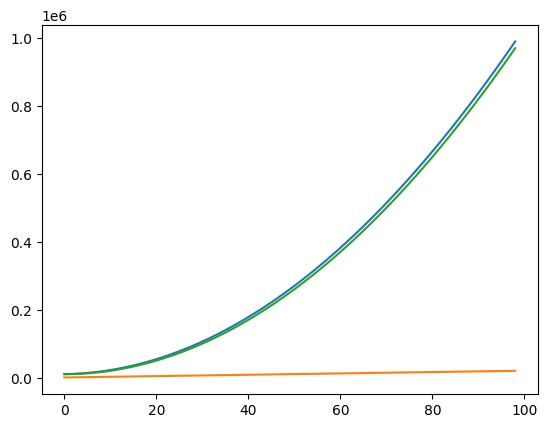

9


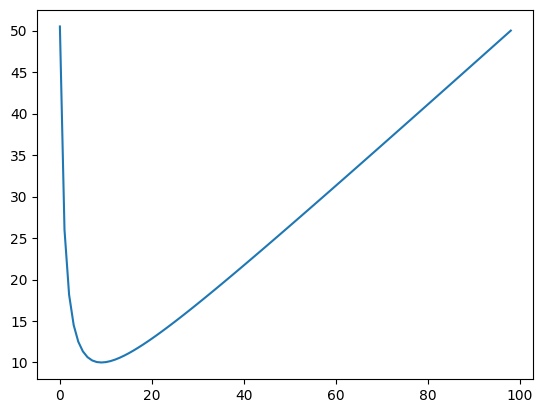

In [345]:
pbp = []
capex = []
revs = []
for x in range(1,100):
    capacity = x 
    
    initial_cost = 10000 + 100 * x**2
    revenue_per_year = 200 * x
    
    capex.append(initial_cost)
    revs.append(revenue_per_year)
    
    payback = initial_cost/revenue_per_year
    
    pbp.append(payback)
    
plt.plot(capex)
plt.plot(revs)
plt.plot([i - j for i,j in zip(capex,revs)])
plt.show()
plt.plot(pbp)
print(np.argmin(pbp))

def calculate_payback_period(initial_investment, revenue_per_year):

    
    return initial_investment/revenue_per_year

# Define the cash flow function
def cash_flow(x):
    initial_cost = 50000 + 100 * x**2
    revenue_per_year = 200 * x
    return initial_cost/revenue_per_year


# Define the bounds for the capacity (0 kW to 10,000 kW)
bounds = (1, 100)

# Perform optimization
result = minimize_scalar(cash_flow, bounds=bounds, method='bounded')

# Extract the optimal capacity
optimal_capacity = result.x

# Calculate the minimum cash flow
min_cash_flow = result.fun

# Print the results
print("Optimal Rated Capacity: {:.2f} kW".format(optimal_capacity))
print("Minimum Payback Period: {:.2f}".format(min_cash_flow))



### Tier 1: Real parameters except solar capacity costs, simple payback period

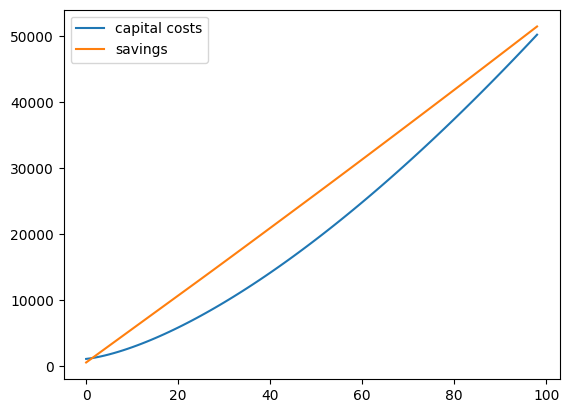

Optimal Rated Capacity: 11.70 kW
Minimum Payback Period: 0.51


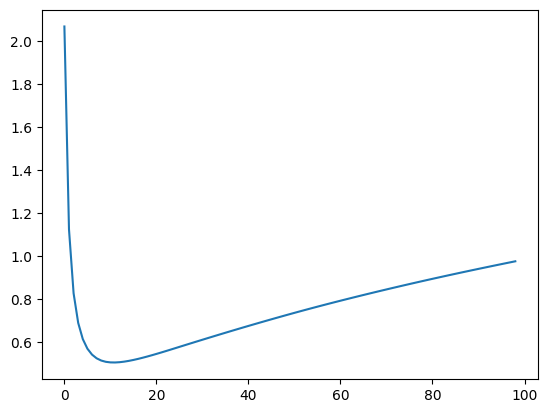

In [403]:
coes = []
npvs = []
c_wo_pv= []
c_w_pv=[]
cash_flowses=[]
capital_costs = []
annual_revenue= []
payback_periods = []
# Arguments
a = [annual_insolation_profile, #list (length 8760)
     pv_efficiency, # int 
     load_profile, #list (length 8760)
     energy_usage_cost, # int
     Rproj, # int
     pv_cost_per_kw, # int
     i_no, # int
     f, # int
     discount_rate] #  int 

for x in range(1,100):

    pv_output_profile = get_pv_output(a[0], a[1], x) # (list, length 8760) PV output profile in each hour of the year
        
    #cost_without_pv, cost_with_pv = cost_of_charging(a[2], pv_output_profile, a[3]) # (list, list, both length 8760) costs of charging in each hour of the year, with and without PV 
    net_load_profile = a[2] - pv_output_profile 
    
    cost_without_pv, cost_with_pv = get_cost_of_charging(a[2], net_load_profile,
                         time_of_use_tariffs, time_periods, feed_in_tariff)
    
  #  cash_flows = calculate_cash_flows(cost_without_pv, cost_with_pv, a[4], a[-1]) # (list, length Rproj) cash savings in each year from PV

    capital_cost =  1000 + a[5] * x**1.5# (int) capital cost of PV system 
    
    revenue_per_year = cost_without_pv.sum() - cost_with_pv.sum() # (float) revenue per year from PV system
    #coe, npv = calculate_cost_of_energy(a[4], a[6], a[7], a[8], 
                              #      capital_cost,cash_flows, load_profile, net_load_profile) # (float) average cost of energy over project lifetime
    
    annual_revenue.append(revenue_per_year)
    
    capital_costs.append(capital_cost)
    
    payback_periods.append(capital_cost/revenue_per_year)
    
plt.plot(capital_costs, label = 'capital costs')
plt.plot(annual_revenue, label = 'savings')

plt.legend()
plt.show()
plt.plot(payback_periods, label = 'payback period')


def payback_period(x, a):
    
    pv_output_profile = get_pv_output(a[0], a[1], x)
        
    net_load_profile = a[2] - pv_output_profile 
    
    cost_without_pv, cost_with_pv = get_cost_of_charging(a[2], net_load_profile,
                         time_of_use_tariffs, time_periods, feed_in_tariff)
    

    capital_cost =  1000 + a[5] * x**1.5# (int) capital cost of PV system 
    
    revenue_per_year = cost_without_pv.sum() - cost_with_pv.sum() # (float) revenue per year from PV system

    #coe, npv = calculate_cost_of_energy(a[4], a[6], a[7], a[8], 
                              #      capital_cost,cash_flows, load_profile, net_load_profile) # (float) average cost of energy over project lifetime
   # coes.append(coe)
   # payback_period = capital_cost/revenue_per_year
    return capital_cost/revenue_per_year

# Define the bounds for the capacity (0 kW to 10,000 kW)
bounds = (1, 100)

# Perform optimization
result = minimize_scalar(payback_period, args = (a,), bounds=bounds, method='bounded')

# Extract the optimal capacity
optimal_capacity = result.x

# Calculate the minimum cash flow
min_cash_flow = result.fun

# Print the results
print("Optimal Rated Capacity: {:.2f} kW".format(optimal_capacity))
print("Minimum Payback Period: {:.2f}".format(min_cash_flow))

### Tier 2: Real numbers except solar investment costs, lifetime value of investment WITH feed-in-tariff  

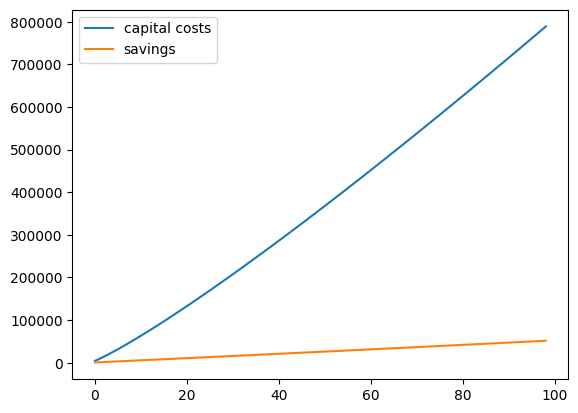

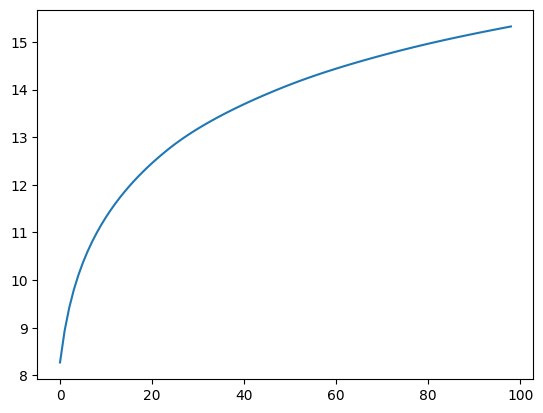

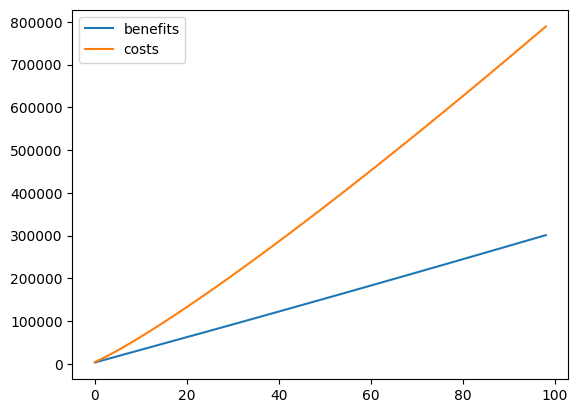

Optimal Rated Capacity: 11.61 kW
Maximum NPV : $9857.81


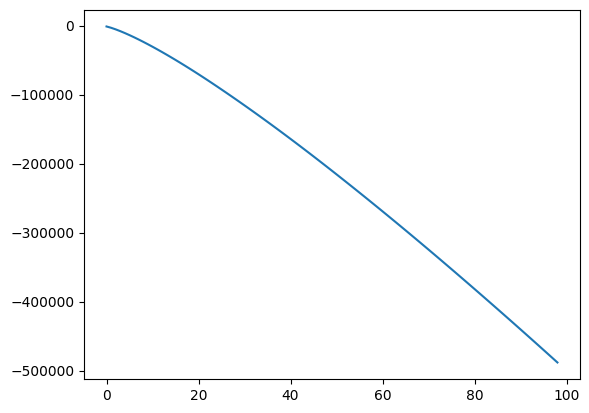

In [445]:
capital_costs = []
annual_revenue= []
payback_periods = []
npvs = []
tb = []
tc = []
tv = []
a = [annual_insolation_profile, #list (length 8760)
     pv_efficiency, # int 
     load_profile, #list (length 8760)
     energy_usage_cost, # int
     Rproj, # int
     pv_cost_per_kw, # int
     i_no, # int
     f, # int
     discount_rate,
     time_of_use_tariffs,
     time_periods,
     feed_in_tariff] #  int 
def calculate_npv(initial_investment, cash_flows, discount_rate):
    values = []
    for idx, cash_flow in enumerate(cash_flows):
        this_year_value = cash_flow /(1 + discount_rate)**idx
        values.append(this_year_value)
    total_benefits = sum(values)
    total_costs = initial_investment
    npv = total_benefits - total_costs
    return total_benefits, total_costs, npv

# def calculate_npv(initial_investment, cash_flows, discount_rate):
#     npv = -initial_investment
#     for idx, cash_flow in enumerate(cash_flows):
#         this_year_value = cash_flow / (1 + discount_rate) ** idx
#         npv += this_year_value
#     return npv


for x in range(1,100):

    pv_output_profile = get_pv_output(a[0], a[1], x) # (list, length 8760) PV output profile in each hour of the year
        
    #cost_without_pv, cost_with_pv = cost_of_charging(a[2], pv_output_profile, a[3]) # (list, list, both length 8760) costs of charging in each hour of the year, with and without PV 
    net_load_profile = a[2] - pv_output_profile 
    
    cost_without_pv, cost_with_pv = get_cost_of_charging(a[2], net_load_profile,
                         time_of_use_tariffs, time_periods, feed_in_tariff)
    
  #  cash_flows = calculate_cash_flows(cost_without_pv, cost_with_pv, a[4], a[-1]) # (list, length Rproj) cash savings in each year from PV

    capital_cost =  200 + a[5] * x**1.15 # (int) capital cost of PV system 
    
    revenue_per_year = cost_without_pv.sum() - cost_with_pv.sum() # (float) revenue per year from PV system
    #coe, npv = calculate_cost_of_energy(a[4], a[6], a[7], a[8], 
                              #      capital_cost,cash_flows, load_profile, net_load_profile) # (float) average cost of energy over project lifetime
    
    annual_revenue.append(revenue_per_year)
    
    capital_costs.append(capital_cost)
    
    payback_periods.append(capital_cost/revenue_per_year)
    
    # Example usage
    cash_flows = [revenue_per_year for i in range(Rproj)]

    total_benefits, total_costs, npv = calculate_npv(capital_cost, cash_flows, a[-1])
    
    tb.append(total_benefits)
    tc.append(total_costs)
    npvs.append(npv)
    
    
plt.plot(capital_costs, label = 'capital costs')
plt.plot(annual_revenue, label = 'savings')

plt.legend()
plt.show()
plt.plot(payback_periods, label = 'payback period')

plt.show()
plt.plot(tb, label = 'benefits')
plt.plot(tc, label = 'costs')
plt.legend()
plt.show()
plt.plot(npvs, label = 'value')



def solar_investment_npv(x, a):
    
    pv_output_profile = get_pv_output(a[0], a[1], x) # (list, length 8760) PV output profile in each hour of the year
        
    net_load_profile = a[2] - pv_output_profile 
    
    cost_without_pv, cost_with_pv = get_cost_of_charging(a[2], net_load_profile,
                         a[-3], a[-2], a[-1])
    
    capital_cost =  200 + a[5] * x**1.15 # (int) capital cost of PV system 
    
    revenue_per_year = cost_without_pv.sum() - cost_with_pv.sum() # (float) revenue per year from PV system
    
    cash_flows = [revenue_per_year for i in range(a[4])]

    total_benefits, total_costs, npv = calculate_npv(capital_cost, cash_flows, a[-4])
    
    return -npv 

bounds = (1, 100)

# Perform optimization
result = minimize_scalar(solar_investment_npv, args = (a,), bounds=bounds, method='bounded')

# Extract the optimal capacity
optimal_capacity = result.x

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal Rated Capacity: {:.2f} kW".format(optimal_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))

### Tier 3: Include effects of fixed battery size, NO Feed in tariff 
Next optimization will need to include multiple decision variables

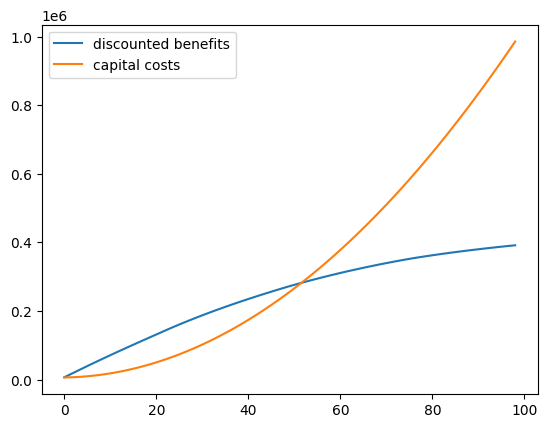

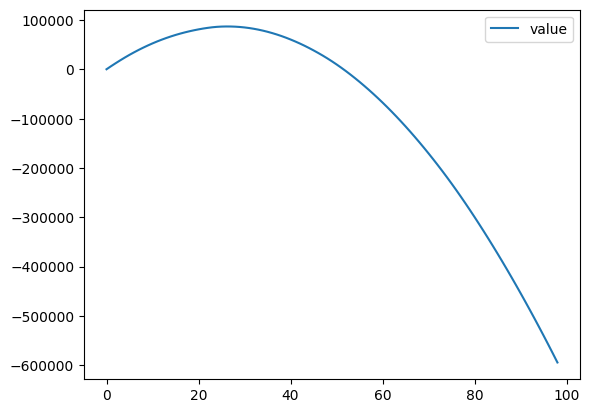

Optimal Rated Capacity: 27.26 kW
Maximum NPV : $87264.61


In [617]:
capital_costs = []
annual_revenue = []
payback_periods = []
npvs = []
tb = []
tc = []
tv = []
max_battery_capacity = 20
battery_cost_per_kWh = 300 # $/kWh
a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': 50,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh
}


def calculate_npv(initial_investment, cash_flows, discount_rate):
    values = []
    for idx, cash_flow in enumerate(cash_flows):
        this_year_value = cash_flow /(1 + discount_rate)**idx
        values.append(this_year_value)
    total_benefits = sum(values)
    total_costs = initial_investment
    npv = total_benefits - total_costs
    return total_benefits, total_costs, npv




for x in range(1,100):

    pv_output_profile = get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], x) # (list, length 8760) PV output profile in each hour of the year
            
    net_load_profile = simulate_battery_storage(a['load_profile'], pv_output_profile, max_battery_capacity) # last argument to be made a DV in next round of optimization 


    pv_capital_cost =  a['pv_cost_per_kw'] * x**2   # (int) capital cost of PV system 
    battery_capital_cost = max_battery_capacity * a['battery_cost_per_kWh'] # (int) capital cost of battery
    total_capital_cost = pv_capital_cost + battery_capital_cost
    
    # FEED-IN-TARIFF = FALSE
    energy_cost_without_pv, energy_cost_with_pv = get_cost_of_charging(a['load_profile'], net_load_profile,
                        a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = False)
    
    revenue_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from PV system
    
    
    annual_revenue.append(revenue_per_year)
    
    
    
    capital_costs.append(total_capital_cost)
    
    payback_periods.append(capital_cost/revenue_per_year)
    
    # Example usage
    cash_flows = [revenue_per_year for i in range(a['Rproj'])]

    total_benefits, total_costs, npv = calculate_npv(pv_capital_cost + total_capital_cost, cash_flows, a['discount_rate'])
    
    tb.append(total_benefits)
    tc.append(total_costs)
    npvs.append(npv)
    
    
plt.plot(tb, label = 'discounted benefits')
plt.plot(tc, label = 'capital costs')
plt.legend()
plt.show()
plt.plot(npvs, label = 'value')
plt.legend()
plt.show()


def solar_and_battery_investment_npv(x, a):
    
    pv_output_profile = get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], x) # (list, length 8760) PV output profile in each hour of the year
            
    net_load_profile = simulate_battery_storage(a['load_profile'], pv_output_profile, max_battery_capacity) # last argument to be made a DV in next round of optimization 


    pv_capital_cost =  a['pv_cost_per_kw'] * x**2   # (int) capital cost of PV system 
    battery_capital_cost = a['battery_cost_per_kWh'] * max_battery_capacity # (int) capital cost of battery
    total_capital_cost = pv_capital_cost + battery_capital_cost
    
    # FEED-IN-TARIFF = FALSE
    energy_cost_without_pv, energy_cost_with_pv = get_cost_of_charging(a['load_profile'], net_load_profile,
                        a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = False)
    
    revenue_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from PV system
    
    cash_flows = [revenue_per_year for i in range(a['Rproj'])]

    total_benefits, total_costs, npv = calculate_npv(pv_capital_cost + total_capital_cost, cash_flows, a['discount_rate'])
    
    return -npv 

bounds = (1, 100)

# Perform optimization
result = minimize_scalar(solar_and_battery_investment_npv, args = (a,), bounds=bounds, method='bounded')

# Extract the optimal capacity
optimal_capacity = result.x

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal Rated Capacity: {:.2f} kW".format(optimal_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))

### Tier 4: Include battery size as decision variable, NO feed in tariff

In [55]:
capital_costs = []
annual_revenue = []
payback_periods = []
npvs = []
tb = []
tc = []
tv = []
max_battery_capacity = 20
battery_cost_per_kWh = 300 # $/kWh
feed_in_tariff = 0.05 # $/kWh
a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': 50,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': True
}


def calculate_npv(initial_investment, cash_flows, discount_rate):
    values = []
    for idx, cash_flow in enumerate(cash_flows):
        this_year_value = cash_flow /(1 + discount_rate)**idx
        values.append(this_year_value)
    total_benefits = sum(values)
    total_costs = initial_investment
    npv = total_benefits - total_costs
    return total_benefits, total_costs, npv



def solar_and_battery_investment_npv(x, a):
    
    pv_capacity = x[0]
    battery_capacity = x[1]
    
    pv_output_profile = get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) # (list, length 8760) PV output profile in each hour of the year
            
    pv_with_battery_output_profile = simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity) # last argument to be made a DV in next round of optimization 

    net_load_profile = a['load_profile'] - pv_with_battery_output_profile 

    pv_capital_cost =  a['pv_cost_per_kw'] * pv_capacity**2   # (int) capital cost of PV system 
    battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
    total_capital_cost = pv_capital_cost + battery_capital_cost
    
    # FEED-IN-TARIFF = FALSE
    energy_cost_without_pv, energy_cost_with_pv = get_cost_of_charging(a['load_profile'], net_load_profile,
                        a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])
    
    revenue_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from PV system
    
    cash_flows = [revenue_per_year for i in range(a['Rproj'])]

    total_benefits, total_costs, npv = calculate_npv(total_capital_cost, cash_flows, a['discount_rate'])
    
    return -npv 

bounds = [(1,100), (1,100)]

initial_guess = [10,70]

# Perform optimization
result = minimize(solar_and_battery_investment_npv, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity) , 'kW')
print("Optimal battery rating: {:.2f} kW".format(optimal_battery_capacity) , 'kWh')
print("Maximum NPV : ${:.2f}".format(-max_npv))


Optimal PV rating: 49.77 kW kW
Optimal battery rating: 60.36 kW kWh
Maximum NPV : $162086.13


### Tier 5: LOADSHEDDING included - mark some hours as loadshedding <font color = 'orange'> Actually I think you need an entirely new schedule if load shedding is happening, maybe there is scope for me to develop an algorithm that takes a schedule of charging and a schedule of loadshedding (with uncertainty) and develop optimal schedule.. or actually what I would want to do is to design a solar + battery system to work with the actual schedule but minimize the effects of loadshedding?? </font>
<font color = 'lightgreen'> Designate certain hours of the year to be loadshedding hours and see how many of them there are with and without the battery and with and without solar.  <br>
First do an evaluation, then quantify the benefit of operating during loadshedding hours as $$$ cash $$$ gains, and include that in the revenue flows (e.g. each hour of loadshedding prevented = $X)  <br>
in this way, solar provides additional benefits to the charging station by being off grid, and having the battery may provide EXTRA gains OVER the 'just solar' model. Or it may not provide very many, but we'll see


Generating a load shedding schedule and evaluating how that affects the ability of the grid to charge, as well as the effects of the solar / solar + battery on alleviating the negative load shedding effects

In [106]:
def generate_loadshedding_schedule(loadshedding_probability, set_random_seed = True):
    schedule = []
    hours_in_year = 365 * 24  # Assuming a non-leap year
    
    #set random seed
    if set_random_seed:
        random.seed(0)
    
    for _ in range(hours_in_year):
        # Generate a random value between 0 and 1
        random_value = random.random()
        
        # Determine if load shedding occurs based on the random value
        # Adjust the threshold value to control the frequency of load shedding
        if random_value < loadshedding_probability:
            schedule.append(True)  # Load shedding occurs
        else:
            schedule.append(False)  # No load shedding
            
    return schedule
loadshedding_probability = 3776 / 8760
loadshedding_schedule = generate_loadshedding_schedule(loadshedding_probability)

# In load-shedding hours, the grid demand (positive net load) is unmet
# 3 scenarios to check how many hours it affects: no solar/no battery, solar/no battery, solar/battery

# 1. No solar, no battery
kWh_affected = np.array([load_profile[i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
# plt.plot(load_profile, label = 'load profile')
# plt.plot(kWh_affected, label = 'load shedding')
print("Number of hours affected", len(kWh_affected[kWh_affected >0]), 'hours out of ', sum([value for value in loadshedding_schedule if value == True]), 'load shedding hours')
print("kWh of charging required to fill the gap", kWh_affected.sum(), 'kWh')

# 2. Solar, no battery
kWh_affected_solar = np.array([net_load_profile[i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
print("Number of hours affected", len(kWh_affected_solar[kWh_affected_solar >0]), 'hours out of ', sum([value for value in loadshedding_schedule if value == True]), 'load shedding hours')
print("kWh of charging required to fill the gap", kWh_affected_solar.sum(), 'kWh')

# 3. Solar, battery
kWh_affected_solar_battery = np.array([net_load_profile_with_battery[i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
print("Number of hours affected", len(kWh_affected_solar_battery[kWh_affected_solar_battery >0]), 'hours out of ', sum([value for value in loadshedding_schedule if value == True]), 'load shedding hours')
print("kWh of charging required to fill the gap", kWh_affected_solar_battery.sum(), 'kWh')

Number of hours affected 3225 hours out of  3717 load shedding hours
kWh of charging required to fill the gap 169598 kWh
Number of hours affected 2876 hours out of  3717 load shedding hours
kWh of charging required to fill the gap 124273.29337135212 kWh
Number of hours affected 2761 hours out of  3717 load shedding hours
kWh of charging required to fill the gap 124217.81751313021 kWh


Including load shedding in the optimization
Currently, it is included by estimating the value of a missed kWh in terms of the amount of passengers that that kWh could have supported, and quantifying the cost of missing a passenger

In [117]:
def get_cost_of_missed_passengers_from_loadshedding(kWh_affected_by_loadshedding: list,
                                                     cost_per_passenger: float,
                                                     time_passenger_per_kWh: float, 
                                                     time_periods: dict):

    # Obtain energy costs for each time period of the day
    morning_passenger_per_kWh = time_passenger_per_kWh['morning'] # (float) number of passengers per kWh in the morning
    afternoon_passenger_per_kWh= time_passenger_per_kWh['afternoon']
    evening_passenger_per_kWh = time_passenger_per_kWh['evening']
    night_passenger_per_kWh = time_passenger_per_kWh['night']
    
    # Obtain time periods for each time period of the day
    morning_start = time_periods['morning_start']
    afternoon_start = time_periods['afternoon_start']
    evening_start = time_periods['evening_start']
    night_start = time_periods['night_start']
    
    # Initialize total cost variables
    passengers_missed = np.zeros(len(kWh_affected_by_loadshedding))
    
    # Calculate total cost of energy with and without PV

    for hour, kWh in enumerate(kWh_affected_by_loadshedding):
        
        curr_hour_of_day = i % 24
        
        if morning_start <= curr_hour_of_day < afternoon_start:
            passengers_missed[hour] = kWh * morning_passenger_per_kWh

        elif afternoon_start <= curr_hour_of_day < evening_start:
            passengers_missed[hour] = kWh * afternoon_passenger_per_kWh
                
        elif evening_start <= curr_hour_of_day < night_start:
            passengers_missed[hour] = kWh * evening_passenger_per_kWh
            
        else:
            passengers_missed[hour] = kWh * night_passenger_per_kWh
            
    return passengers_missed * cost_per_passenger 


In [120]:
capital_costs = []
annual_revenue = []
payback_periods = []
npvs = []
tb = []
tc = []
tv = []
max_battery_capacity = 20
battery_cost_per_kWh = 500 # $/kWh
feed_in_tariff = 0.041 # $/kWh - current South African feed-in-tariff

time_passenger_per_kWh = {'morning': 0.66, 
                          'afternoon': 0.33,
                          'evening': 0.66, 
                          'night': 0.25}

cost_per_passenger = 1 # $/passenger

a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger
}


def calculate_npv(initial_investment, cash_flows, discount_rate):
    values = []
    for idx, cash_flow in enumerate(cash_flows):
        this_year_value = cash_flow /(1 + discount_rate)**idx
        values.append(this_year_value)
    total_benefits = sum(values)
    total_costs = initial_investment
    npv = total_benefits - total_costs
    return total_benefits, total_costs, npv


# def get_cost_of_loadshedding(kWh_affected_by_loadshedding: list):
#     #energy_for_one_trip = avg_trip_distance * avg_kWh_per_km
#     enegy_for_one_trip = 20 * 0.55 # 10km * 0.55 kWh/km
    
#     num_hours_affected = len(kWh_affected[kWh_affected >0])
#     num_trips_missed = kWh_affected.sum() / energy_for_one_trip
    
#     return num_hours_affected, num_trips_missed


def get_cost_of_loadshedding(kWh_affected_by_loadshedding: list):
    #energy_for_one_trip = avg_trip_distance * avg_kWh_per_km
    enegy_for_one_trip = 20 * 0.55 # 10km * 0.55 kWh/km
    
    num_hours_affected = len(kWh_affected[kWh_affected >0])
    num_trips_missed = kWh_affected.sum() / energy_for_one_trip
    
    return num_hours_affected, num_trips_missed



def solar_and_battery_with_loadshedding_npv(x, a):
    
    # Decision variables - PV capacity and Battery capacity 
    pv_capacity = x[0]
    battery_capacity = x[1]
    
    # Capital Cost of Investment 
    pv_capital_cost =  a['pv_cost_per_kw'] * pv_capacity**2   # (int) capital cost of PV system 
    battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
    total_capital_cost = pv_capital_cost + battery_capital_cost
    
    # Generate PV Output profile 
    pv_output_profile = get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) # (list, length 8760) PV output profile in each hour of the year
    
    # Generate load shedding schedule 
    loadshedding_schedule = generate_loadshedding_schedule(a['loadshedding_probability'])
    
    
    
    # Generate PV output profile with battery
    pv_with_battery_output_profile = simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity) # last argument to be made a DV in next round of optimization 
    
    # Net charging load profile 
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile

    # Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
    gross_load_affected_by_loadshedding = np.array([load_profile[i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
    saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]
    
    # Profile of kWh that would be lost to load shedding WITH solar and battery
    net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
    gross_load_minus_loadshedding = load_profile - gross_load_affected_by_loadshedding
    net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 
    
    
    #### Quantifying the effects of loadshedding and the value of solar + battery for offsetting it 
    
    # Value of kWh lost to loadshedding WITHOUT solar + battery
    # value_of_charging_lost_to_loadshedding = get_cost_of_missed_passengers_from_loadshedding(gross_load_affected_by_loadshedding, a['cost_per_passenger'],
                                                      #  a['time_passenger_per_kWh'], a['time_periods'] )
    
    # Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
    value_of_charging_saved_by_pv_from_loadshedding = get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                         a['time_passenger_per_kWh'], a['time_periods'])

    # Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
    energy_cost_without_pv, energy_cost_with_pv = get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                         a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])
    
    # Quantify the detriments of load shedding 
    # gross_load_num_hours_affected, gross_load_num_trips_missed = get_cost_of_loadshedding(gross_load_minus_loadshedding)
    # net_load_num_hours_affected, net_load_num_trips_missed = get_cost_of_loadshedding(net_load_minus_loadshedding)
    
    # number of missed trips that are avoided with the solar and battery system
   # avoided_missed_trips = gross_load_num_trips_missed - net_load_num_trips_missed
    # number of hours of loadshedding that are avoided with the solar and battery system

    
    energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from PV system
    
    operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum()
    
    cash_flows = [energy_savings_per_year + operational_savings_per_year for i in range(a['Rproj'])]

    total_benefits, total_costs, npv = calculate_npv(total_capital_cost, cash_flows, a['discount_rate'])
    
    return -npv 

bounds = [(1,100), (1,100)]

initial_guess = [20, 20]

# Perform optimization
result = minimize(solar_and_battery_with_loadshedding_npv, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))


Optimal PV rating: 3.40 kW
Optimal battery rating: 2.65 kWh
Maximum NPV : $11530.69


### Tier 7: Include carbon pricing  (and additional pv capital cost)
No 'time of day' emissions factor yet but that could be simple to implement

In [87]:
capital_costs = []
annual_revenue = []
payback_periods = []
npvs = []
tb = []
tc = []
tv = []
max_battery_capacity = 20
battery_cost_per_kWh = 500 # $/kWh
feed_in_tariff = 0.05 # $/kWh

time_passenger_per_kWh = {'morning': 0.66, 
                          'afternoon': 0.33,
                          'evening': 0.66, 
                          'night': 0.25}

cost_per_passenger = 1 # $/passenger

grid_carbon_intensity = 0.90 # kgCO2/kWh
carbon_price = 50/1000 # $/kgCo2


a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost
}




def get_value_of_carbon_offsets(load_profile, net_load_profile, grid_carbon_intensity, carbon_price):
    carbon_cost_gross_load = load_profile.sum() * grid_carbon_intensity *  carbon_price  # kWh * kgCO2/kWh * $/kgCO2 = $
    carbon_cost_net_load = net_load_profile.sum() * grid_carbon_intensity *  carbon_price  # kWh * kgCO2/kWh * $/kgCO2 = $ 
    return carbon_cost_gross_load - carbon_cost_net_load





def solar_and_battery_with_loadshedding_and_carbon_pricing_npv(x, a):
    
    # Decision variables - PV capacity and Battery capacity 
    pv_capacity = x[0]
    battery_capacity = x[1]
    
    # Capital Cost of Investment 
    pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity ** 1.5   # (int) capital cost of PV system 
    battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
    total_capital_cost = pv_capital_cost + battery_capital_cost
    
    # Generate PV Output profile 
    pv_output_profile = get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) # (list, length 8760) PV output profile in each hour of the year
    
    # Generate load shedding schedule 
    loadshedding_schedule = generate_loadshedding_schedule(a['loadshedding_probability'])
    
    
    
    # Generate PV output profile with battery
    pv_with_battery_output_profile = simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity) # last argument to be made a DV in next round of optimization 
    
    # Net charging load profile 
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile

    # Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
    gross_load_affected_by_loadshedding = np.array([load_profile[i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
    saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]
    
    # Profile of kWh that would be lost to load shedding WITH solar and battery
    net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
    gross_load_minus_loadshedding = load_profile - gross_load_affected_by_loadshedding
    net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 
    
    
    #### Quantifying the effects of loadshedding and the value of solar + battery for offsetting it 

    
    # Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
    value_of_charging_saved_by_pv_from_loadshedding = get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                         a['time_passenger_per_kWh'], a['time_periods'])

    # Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
    energy_cost_without_pv, energy_cost_with_pv = get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                         a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])
    
    ##### Quantify value of  the carbon offsets ######
    carbon_savings_per_year = get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])
    
    
    energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 
    
    operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers
    

    cash_flows = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(a['Rproj'])]

    total_benefits, total_costs, npv = calculate_npv(total_capital_cost, cash_flows, a['discount_rate'])
    
    return -npv 

bounds = [(1,100), (1,100)]

initial_guess = [20, 20]

# Perform optimization
result = minimize(solar_and_battery_with_loadshedding_and_carbon_pricing_npv, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))


Optimal PV rating: 25.17 kW
Optimal battery rating: 18.17 kWh
Maximum NPV : $65888.04


### Tier 8: Include land area usage as constraint

In [121]:
capital_costs = []
annual_revenue = []
payback_periods = []
npvs = []
tb = []
tc = []
tv = []
max_battery_capacity = 20
battery_cost_per_kWh = 500 # $/kWh
feed_in_tariff = 0.05 # $/kWh

time_passenger_per_kWh = {'morning': 0.66, 
                          'afternoon': 0.33,
                          'evening': 0.66, 
                          'night': 0.25}

cost_per_passenger = 1 # $/passenger

grid_carbon_intensity = 0.90 # kgCO2/kWh
carbon_price = 50/1000 # $/kgCo2

pv_m_sq_per_kw = 6 # m^2/kW

max_land_area = 1000 # m^2


a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'pv_m_sq_per_kw': pv_m_sq_per_kw,
    'max_land_area': max_land_area
}


def get_value_of_carbon_offsets(load_profile, net_load_profile, grid_carbon_intensity, carbon_price):
    carbon_cost_gross_load = load_profile.sum() * grid_carbon_intensity *  carbon_price  # kWh * kgCO2/kWh * $/kgCO2 = $
    carbon_cost_net_load = net_load_profile.sum() * grid_carbon_intensity *  carbon_price  # kWh * kgCO2/kWh * $/kgCO2 = $ 
    return carbon_cost_gross_load - carbon_cost_net_load





def solar_and_battery_with_loadshedding_and_carbon_pricing_npv(x, a):
    
    # Decision variables - PV capacity and Battery capacity 
    pv_capacity = x[0]
    battery_capacity = x[1]
    
    # Capital Cost of Investment 
    pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity ** 1.5   # (int) capital cost of PV system 
    battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
    total_capital_cost = pv_capital_cost + battery_capital_cost
    
    # Generate PV Output profile 
    pv_output_profile = get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) # (list, length 8760) PV output profile in each hour of the year
    
    # Generate load shedding schedule 
    loadshedding_schedule = generate_loadshedding_schedule(a['loadshedding_probability'])
    
    
    
    # Generate PV output profile with battery
    pv_with_battery_output_profile = simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity) # last argument to be made a DV in next round of optimization 
    
    # Net charging load profile 
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile

    # Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
    gross_load_affected_by_loadshedding = np.array([load_profile[i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
    saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]
    
    # Profile of kWh that would be lost to load shedding WITH solar and battery
    net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
    gross_load_minus_loadshedding = load_profile - gross_load_affected_by_loadshedding
    net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 
    
    
    #### Quantifying the effects of loadshedding and the value of solar + battery for offsetting it 

    
    # Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
    value_of_charging_saved_by_pv_from_loadshedding = get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                         a['time_passenger_per_kWh'], a['time_periods'])

    # Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
    energy_cost_without_pv, energy_cost_with_pv = get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                         a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])
    
    ##### Quantify value of  the carbon offsets ######
    carbon_savings_per_year = get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])
    
    
    energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 
    
    operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers
    

    cash_flows = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(a['Rproj'])]

    total_benefits, total_costs, npv = calculate_npv(total_capital_cost, cash_flows, a['discount_rate'])
    
    return -npv 

bounds = [(1,100), (1,100)]

initial_guess = [20, 20]


# formulate a constraint that x[0] * pv_m_sq_per_kw <= max_land_area
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0
#
# Perform optimization
result = minimize(solar_and_battery_with_loadshedding_and_carbon_pricing_npv, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP', constraints = constraint)

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))


Optimal PV rating: 26.04 kW
Optimal battery rating: 11.44 kWh
Maximum NPV : $69091.78


### Tier 8.5: Re-including feed in tariff with the loadshedding simulation
<font color ='orange'> I believe this works, but should explore the interactions of increased feed-in tariff with the optimal result, because it does decrease the optimal battery size- interesting to look at </font>

In [135]:
capital_costs = []
annual_revenue = []
payback_periods = []
npvs = []
tb = []
tc = []
tv = []
max_battery_capacity = 20
battery_cost_per_kWh = 500 # $/kWh
feed_in_tariff = 0.041 # $/kWh

time_passenger_per_kWh = {'morning': 0.66, 
                          'afternoon': 0.33,
                          'evening': 0.66, 
                          'night': 0.25}

cost_per_passenger = 1 # $/passenger

grid_carbon_intensity = 0.90 # kgCO2/kWh
carbon_price = 50/1000 # $/kgCo2

pv_m_sq_per_kw = 6 # m^2/kW

max_land_area = 1000 # m^2


a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': True,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'pv_m_sq_per_kw': pv_m_sq_per_kw,
    'max_land_area': max_land_area
}


def get_value_of_carbon_offsets(load_profile, net_load_profile, grid_carbon_intensity, carbon_price):
    carbon_cost_gross_load = load_profile.sum() * grid_carbon_intensity *  carbon_price  # kWh * kgCO2/kWh * $/kgCO2 = $
    carbon_cost_net_load = net_load_profile.sum() * grid_carbon_intensity *  carbon_price  # kWh * kgCO2/kWh * $/kgCO2 = $ 
    return carbon_cost_gross_load - carbon_cost_net_load





def solar_and_battery_with_loadshedding_and_carbon_pricing_npv(x, a):
    
    # Decision variables - PV capacity and Battery capacity 
    pv_capacity = x[0]
    battery_capacity = x[1]
    
    # Capital Cost of Investment 
    pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity ** 1.5   # (int) capital cost of PV system 
    battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
    total_capital_cost = pv_capital_cost + battery_capital_cost
    
    # Generate PV Output profile 
    pv_output_profile = get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) # (list, length 8760) PV output profile in each hour of the year
    
    # Generate load shedding schedule 
    loadshedding_schedule = generate_loadshedding_schedule(a['loadshedding_probability'])
    
    
    # Generate PV output profile with battery
    pv_with_battery_output_profile = simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity) # last argument to be made a DV in next round of optimization 
    
    # Net charging load profile 
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile

    # Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
    gross_load_affected_by_loadshedding = np.array([load_profile[i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
    saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]
    
    # Profile of entire kWh produced by PV during loadshedding
    kWh_produced_by_pv_during_loadshedding = [pv_with_battery_output_profile[i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]
    feed_in_kWh_from_pv_during_loadshedding = [i - j for i,j in zip(kWh_produced_by_pv_during_loadshedding, saved_free_kWh)]
    
    # Value of PV fed to the grid during loadshedding (perhaps this should be boosted with a scalar to account for the increased value of energy during loadshedding)
    feed_in_during_loadshedding_value = sum(feed_in_kWh_from_pv_during_loadshedding) * a['feed_in_tariff']

    
    # Profile of kWh that would be lost to load shedding WITH solar and battery
    net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
    gross_load_minus_loadshedding = load_profile - gross_load_affected_by_loadshedding
    net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 
    
    
    #### Quantifying the effects of loadshedding and the value of solar + battery for offsetting it 

    
    # Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
    value_of_charging_saved_by_pv_from_loadshedding = get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                         a['time_passenger_per_kWh'], a['time_periods'])

    # Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
    energy_cost_without_pv, energy_cost_with_pv = get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                         a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])
    
    ##### Quantify value of  the carbon offsets ######
    carbon_savings_per_year = get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])
    
    
    energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 
    
    operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers
    

    cash_flows = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year + feed_in_during_loadshedding_value for i in range(a['Rproj'])]

    total_benefits, total_costs, npv = calculate_npv(total_capital_cost, cash_flows, a['discount_rate'])
    
    return -npv 

bounds = [(1,100), (1,100)]

initial_guess = [20, 20]


# formulate a constraint that x[0] * pv_m_sq_per_kw <= max_land_area
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0
#
# Perform optimization
result = minimize(solar_and_battery_with_loadshedding_and_carbon_pricing_npv, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP', constraints = constraint)

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))


Optimal PV rating: 26.56 kW
Optimal battery rating: 4.09 kWh
Maximum NPV : $71114.92


### <font color = 'orange'> Tier 9: Optimize battery model (without accounting for loadshedding) </font>

In [115]:

a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'pv_m_sq_per_kw': pv_m_sq_per_kw,
    'max_land_area': max_land_area
}

def get_battery_discharge_profile(load_profile, pv_output_profile, max_battery_capacity):

    battery_state = 0  # Initial state of the battery

    storage_profile = np.zeros(len(pv_output_profile)) # Initialize an array to keep track of the energy stored in the battery
    discharge_profile = np.zeros(len(pv_output_profile)) # Initialize an array to keep track of the energy discharged from the battery
    curtailed_energies = np.zeros(len(pv_output_profile)) # Initialize an array to keep track of the wasted energies
    battery_states = np.zeros(len(pv_output_profile)) # Initialize an array to keep track of the battery state
    
    for hour, load in enumerate(load_profile):
        
        net_load = load - pv_output_profile[hour]  # Calculate the net load profile
        
        battery_room = max_battery_capacity - battery_state # Calculate the amount of room left in the battery
        
        energy_stored = 0
        energy_discharged = 0
        curtailed_energy = 0
        
        if net_load < 0:
            # The PV system is producing more energy than the load requires
            # Charge the battery with the excess energy
            energy_stored = min(battery_room, -net_load)
            battery_state = battery_state + energy_stored
            curtailed_energy = -net_load - energy_stored
            
        elif net_load > 0:
            # The PV system is producing less energy than the load requires
            # Discharge the battery to assist with the load 
            energy_discharged = min(battery_state, net_load)
            battery_state = battery_state - energy_discharged
            
        curtailed_energies[hour] = curtailed_energy
        battery_states[hour] = battery_state
        storage_profile[hour] = energy_stored
        discharge_profile[hour] = energy_discharged
        

    return discharge_profile

def objective(x, a):
    # Decision variables - PV capacity and Battery capacity 
    pv_capacity = 25
    battery_capacity = 15
    
    # Generate PV Output profile 
    pv_output_profile = get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) # (list, length 8760) PV output profile in each hour of the year
    
    # Generate load shedding schedule 
    loadshedding_schedule = generate_loadshedding_schedule(a['loadshedding_probability'])
    
    discharge_profile = get_battery_discharge_profile(load_profile, pv_output_profile, battery_capacity)
    
    discharge_values = np.zeros(len(discharge_profile))
    
    for hour, energy_discharged in enumerate(discharge_profile):
        curr_hour = hour % 24
        # Determine value of discharging in this hour 
        if a['time_periods']['morning_start'] < curr_hour < a['time_periods']['afternoon_start']:
            
            if loadshedding_schedule[hour]:
                discharge_values[hour] = a['time_passenger_per_kWh']['morning'] 
            else:
                discharge_values[hour] = a['time_of_use_tariffs']['morning']
                
        elif a['time_periods']['afternoon_start'] < curr_hour < a['time_periods']['evening_start']:
            
            if loadshedding_schedule[hour]:
                discharge_values[hour] = a['time_passenger_per_kWh']['afternoon'] 
            else:
                discharge_values[hour] = a['time_of_use_tariffs']['afternoon']  
                    
        elif a['time_periods']['evening_start'] < curr_hour < a['time_periods']['night_start']:  
            
            if loadshedding_schedule[hour]:
                discharge_values[hour] = a['time_passenger_per_kWh']['evening'] 
            else:
                discharge_values[hour] = a['time_of_use_tariffs']['evening']    
                    
        else:
            if loadshedding_schedule[hour]:
                discharge_values[hour] = a['time_passenger_per_kWh']['night'] 
            else:
                discharge_values[hour] = a['time_of_use_tariffs']['night']
                
    x = (discharge_values * discharge_profile).sum() 
                
    return -x

initial_discharge_profile = np.zeros(len(load_profile))

initial_guess = [initial_discharge_profile]

# Perform optimization
result = minimize(objective, x0 = initial_discharge_profile, args = (a,), method='SLSQP')

# def simulate_optimal_battery_profile(load_profile, pv_output_profile, loadshedding_schedule, max_battery_capacity, a):
    
# Extract the optimal capacity
optimal_discharge_profile = result.x

# Calculate the minimum cash flow
max_earnings = result.fun

# Print the results
plt.plot(optimal_discharge_profile)
print("earnings:", -max_npv)

KeyboardInterrupt: 

In [ ]:

a = {
    'annual_insolation_profile': annual_insolation_profile,
    'pv_efficiency': pv_efficiency,
    'load_profile': load_profile,
    'energy_usage_cost': energy_usage_cost,
    'Rproj': Rproj,
    'pv_cost_per_kw': pv_cost_per_kw,
    'i_no': i_no,
    'f': f,
    'discount_rate': discount_rate,
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    'battery_cost_per_kWh': battery_cost_per_kWh,
    'feed_in_tariff_bool': False,
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    'additional_pv_capital_cost': additional_pv_capital_cost,
    'pv_m_sq_per_kw': pv_m_sq_per_kw,
    'max_land_area': max_land_area
}

def simulate_with_optimal_battery_profile(x, a):
    
    # Decision variables - PV capacity and Battery capacity 
    pv_capacity = x[0]
    battery_capacity = x[1]
    
    # Capital Cost of Investment 
    pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity ** 1.5   # (int) capital cost of PV system 
    battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
    total_capital_cost = pv_capital_cost + battery_capital_cost
    
    # Generate PV Output profile 
    pv_output_profile = get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) # (list, length 8760) PV output profile in each hour of the year
    
    # Generate load shedding schedule 
    loadshedding_schedule = generate_loadshedding_schedule(a['loadshedding_probability'])
    
    
    
    # Generate PV output profile with battery
    pv_with_battery_output_profile = simulate_optimal_battery_profile(a['load_profile'], pv_output_profile, loadshedding_schedule, battery_capacity, a)
    
    # Net charging load profile 
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile

    # Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
    gross_load_affected_by_loadshedding = np.array([load_profile[i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
    saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]
    
    # Profile of kWh that would be lost to load shedding WITH solar and battery
    net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
    gross_load_minus_loadshedding = load_profile - gross_load_affected_by_loadshedding
    net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 
    
    
    #### Quantifying the effects of loadshedding and the value of solar + battery for offsetting it 

    
    # Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
    value_of_charging_saved_by_pv_from_loadshedding = get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                         a['time_passenger_per_kWh'], a['time_periods'])

    # Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
    energy_cost_without_pv, energy_cost_with_pv = get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                         a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])
    
    ##### Quantify value of  the carbon offsets ######
    carbon_savings_per_year = get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])
    
    
    energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 
    
    operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers
    

    cash_flows = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(a['Rproj'])]

    total_benefits, total_costs, npv = calculate_npv(total_capital_cost, cash_flows, a['discount_rate'])
    
    return -npv 

bounds = [(1,100), (1,100)]

initial_guess = [20, 20]


# formulate a constraint that x[0] * pv_m_sq_per_kw <= max_land_area
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0
#
# Perform optimization
result = minimize(solar_and_battery_with_loadshedding_and_carbon_pricing_npv, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP', constraints = constraint)

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV : ${:.2f}".format(-max_npv))


### Tier 10: Optimize battery charge and discharge (accounting for loadshedding)

### Todo:
0. Include feed in tariff in the ones with the battery?
0. <font color = 'orange'> Adjust the battery model to prioritize discharge during non-loadshedding hours (we can probably actually optimize the discharge profile since it is known - i.e. optimize it to minimize load shedding hours, or optimize it to minimize total expected cost (including the cost of loadshedding hours)) </font> - <font color = 'lightblue'> Meeting with Becky to discuss </font>
0. <font color = 'yellow'> Include capacity (kW) in the battery optimization (speed at which the battery can charge) </font>
2. Include power system gains (voltage stability, reliability?) evaluation, then include that in the objective function somehow... 
    1. include reliability in obj fun?
3. Include charging and discharging efficiency for the battery
4. Make the capital cost assumptions more realistique 

###

### Non-gradient optimizer

In [239]:
import scipy.optimize as spo

#initial_guess = [10] # Example initial guess: [10]
problem = spo.differential_evolution(objective, args = (a,), bounds=bounds, maxiter = 100)
print(problem)

RuntimeError: func(x, *args) must return a scalar value

# Further work

Electrical parameters of PV station, example from https://www.mdpi.com/1996-1073/8/11/13265#B16-energies-08-12368

Maximum Power (Pmax)	250 W <br>
Power Tolerance	(0, 5) W<br>
Maximum Power Voltage (Vmp)	30.7 V<br>
Maximum Power Current (Imp)	8.14 A<br>
Open Circuit Voltage (Voc)	37.90 V<br>
Short Circuit Current (Isc)	8.72 A<br>
Module Efficiency (ηm)	17.03%<br>
Dimension of module	1480 mm × 992 mm × 40 mm<br>

A power converter is required to maintain the energy flow between the direct current (DC) and alternating current (AC) components in a hybrid wind/PV/battery power system

Table 3. Electrical parameters of the Suntree 30000 TL inverter.<br>
Characteristics	Value<br>
Max. output power	30 kW<br>
Max. output current	48 A<br>
MPPT Voltage Range	400–800 Vdc<br>
Nominal AC voltage	400 V<br>
Harmonic distortion (THDI)	<3% (at nominal output power)<br>
Max. efficiency	>98.2%<br>
Dimensions (W/L/H)	580 mm × 235 mm × 800 mm<br>
Net weight	60 kg

EV battery technical params

Table 4. Main technical parameters of the BYD E6 battery.
Characteristics	Value
Battery material	LiFePO4
Single Cell Voltage	3.2–3.3 V
Nominal Voltage	316.8 V
Nominal Capacity	200 Ah
Energy density	100 Wh/kg
Total weight	600 kg
Efficiency	85%

other: max capacit of grid purchase power and TOU tariffs. carbon pricing, feed-in tariff, interest rate

esitmte NPC and COE??? (cost of energy and net present cost)

Land requirements m^2 / kW * max capacity (kW)

Sensitivities: <br
1. capital cost
2. carbon pricing
3. feed-in tariff
4. interest rates <br>

line graphs or scatter plots with above variable on X axis and COE (cost of energy) on Y axis

include solar + battery scenario? (first, evaluate how much solar is being wasted in the middle of the day) (second, even if no solar is wasted i.e. all is used for EV, evaluate the economic benefit of shifting the solar charging to evening or night with the battery?)